# Mouse primary visual cortex dataset

We present analysis of the ISH-based mouse primary visual cortex STARmap dataset. This data can be obtained from the website (https://www.starmapresources.com/data).And its annotation can be obtained from our github.

## 1. Import packages

In [1]:
from matplotlib import pyplot as plt
from DeepGFT.utils import *
from DeepGFT.genenet import obtain_genenet
from DeepGFT.train import *
import torch
import scanpy as sc
import warnings
from sklearn.metrics import adjusted_rand_score

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_all(2023)

/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
# Read data
adata = sc.read_h5ad('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/STARmap_20180505_BY3_1k.h5ad')

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
# Data preprocessing
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)
adata, adata_raw = svg(adata, svg_method='gft_top', n_top=3000)

## 4. Construct network and GFT

Construct spot-spot network and gene co-expression network, and the graph Fourier transform was performed respectively. Obtain signal features of spots and genes.

In [4]:
# Build spotnet and genenet
obtain_spotnet(adata, knn_method='Radius', rad_cutoff=500, prune=False)
gene_freq_mtx, gene_eigvecs_T, gene_eigvals = f2s_gene(adata, gene_signal=256, c1=5)
obtain_genenet(adata, dataset='pearson', cut=0.2)
spot_freq_mtx, spot_eigvecs_T, spot_eigvals = f2s_spot(adata, spot_signal=256, middle=2, c2=0.005)

gene edges 6496 spots 1207


## 5. Train GAT module

In [5]:
# Train GAT
res, lamda, emb_spot, _, attention = train_spot(adata, gene_freq_mtx, gene_eigvecs_T, spot_freq_mtx, spot_eigvecs_T,
                                                alpha=20, device=device, epoch_max=200, cluster=False)

spot*signal train


100%|██████████| 200/200 [00:03<00:00, 59.91it/s]


## 6. Downstream analysis

### Spatial cluster

In [6]:
adata.obsm['emb'] = emb_spot
sc.pp.neighbors(adata, use_rep='emb')
cluster_num = len(adata.obs['label'].unique())
adata = mclust_R(adata, used_obsm='emb', num_cluster=cluster_num)
ARI_m = adjusted_rand_score(adata.obs['mclust'], adata.obs['label'])
print('ARI', ARI_m)

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R
INFO:rpy2.situation:R library path: /apps/cuda/11.6.1/lib64
INFO:rpy2.situation:LD_LIBRARY_PATH: /apps/cuda/11.6.1/lib64
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI 0.6039633592779274


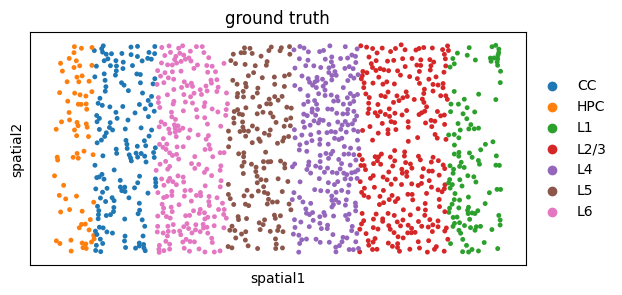

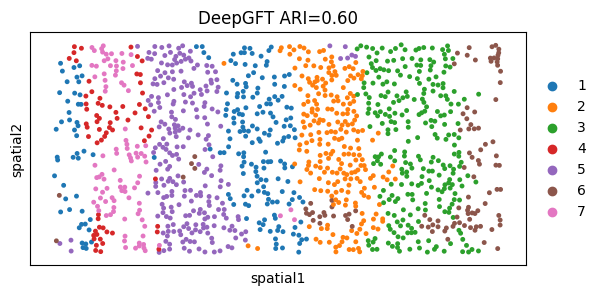

In [7]:
sc.pl.spatial(adata, color=['label'], title=['ground truth'], spot_size=150)
sc.pl.spatial(adata, color=['mclust'], title=['DeepGFT ARI=%.2f'%ARI_m], spot_size=150)

### Gene denoise

In [8]:
res_denoising, att = denoising(res, adata.uns['spotnet_adj'], attention[:, 0])
adata_res = adata.copy()
adata_res.X = res_denoising
svgs = ['Lamp5', 'Nrsn1', 'Cplx1', 'Nptx1']

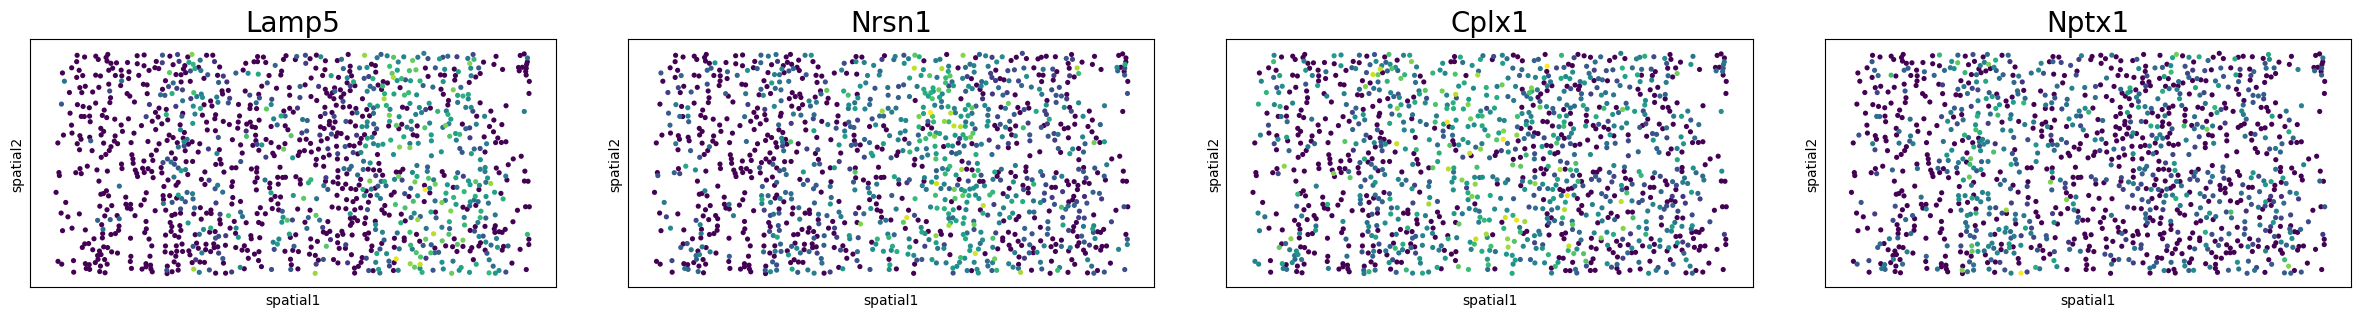

In [9]:
# Before noise reduction
plt.rcParams.update({'axes.titlesize':20})
sc.pl.spatial(adata_raw, color=svgs, spot_size=150, colorbar_loc=None)

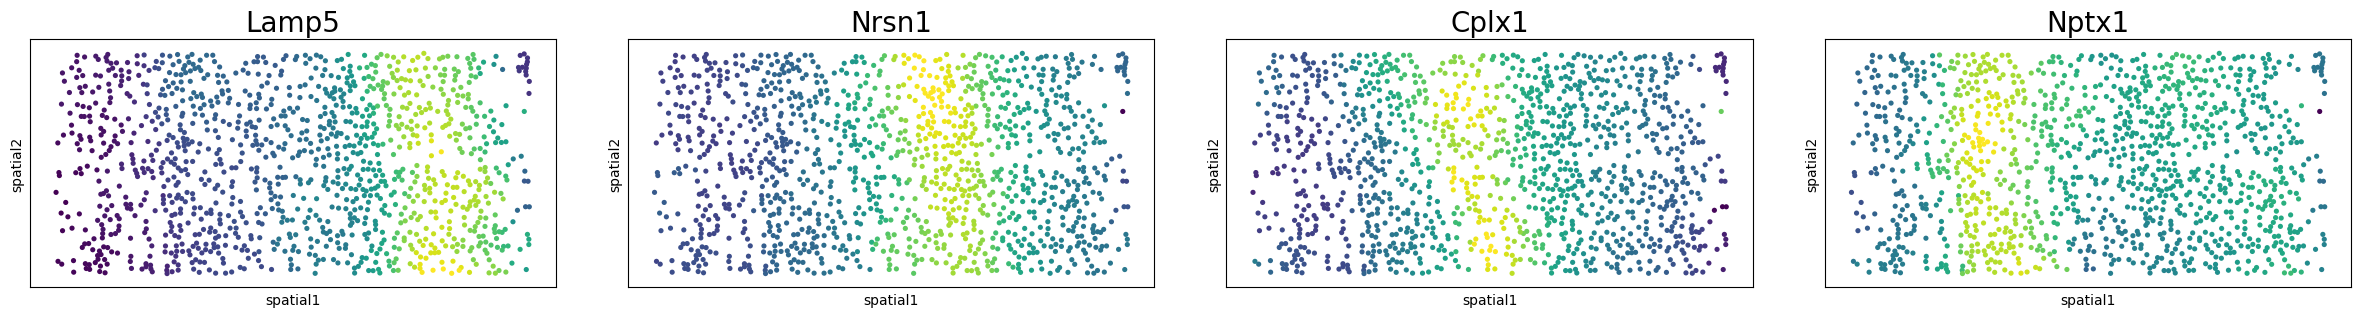

In [10]:
# After noise reduction
plt.rcParams.update({'axes.titlesize':20})
sc.pl.spatial(adata_res, color=svgs, spot_size=150, colorbar_loc=None)